In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram


In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv("C:\\Users\\ASUS\\Desktop\\220710045_220710012_230710079\\creditcard.csv")
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Veri kümesi dengesizliğine bakalım:

In [4]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



Verileri temizleyelim, bölüp ve normalleştirelim:

In [5]:
cleaned_df = raw_df.copy()

cleaned_df.pop('Time')

eps = 0.001 
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

In [6]:
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [7]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


Veri dağılımına bakalım:

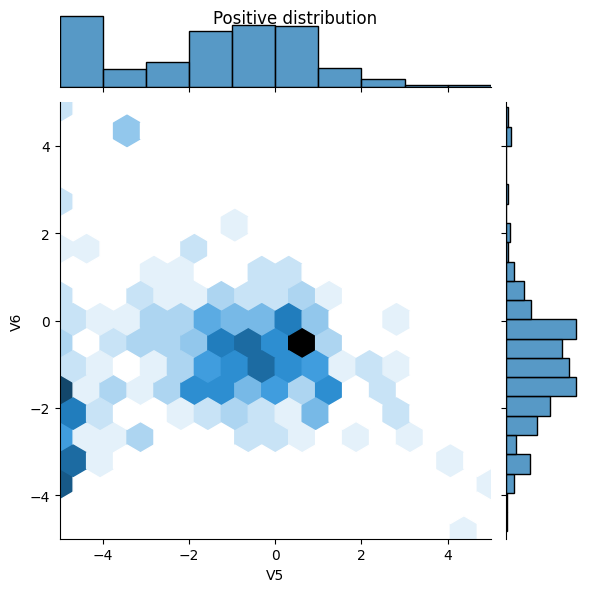

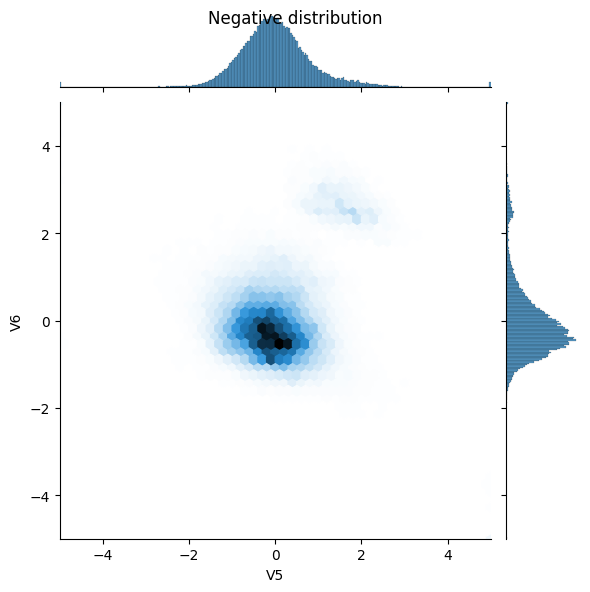

In [8]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

Sınıf Bilgileri -->

In [9]:
sinif_dagilimi = raw_df['Class'].value_counts()
print(sinif_dagilimi)

Class
0    284315
1       492
Name: count, dtype: int64


Eksik değerlerin analizi ve giderilmesi -->

In [10]:
# Eksik değerleri tespit edelim
eksik_veri_sayisi = raw_df.isnull().sum().sum()
print(f"Eksik değerler: {eksik_veri_sayisi}")
print(raw_df.isnull().sum())

Eksik değerler: 0
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


Veri seti içindeki özelliklerin sınıflamada ki ayırt ediciliklerine göre sıralanması -->

In [11]:
X = raw_df.iloc[:1000, :]  # İlk 1000 satır
y = raw_df.loc[:999, 'Class']  # Hedef değişken için ilk 1000 satır

model = RandomForestClassifier()
model.fit(X, y)
# Özelliklerin önem sırasını alalım
feature_importance = model.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]  # Önem sırasına göre indeksleri sıralama

print("Özelliklerin Sınıflandırmadaki Önem Sırası:")
for i in sorted_indices:
    print(f"{X.columns[i]}: {feature_importance[i]}")

Özelliklerin Sınıflandırmadaki Önem Sırası:
Class: 0.24973535860359644
V12: 0.12024445710099486
V11: 0.09034407212313408
V15: 0.06321571871430406
V10: 0.05293537239797732
V20: 0.04507528085334629
V14: 0.0419607144884622
V23: 0.040457303529939544
V4: 0.036774200837128505
V9: 0.035438320126075666
V5: 0.025426860425034538
V21: 0.021906567298823083
Amount: 0.020561554285756335
V1: 0.019475949520510984
V17: 0.017758535428674047
V28: 0.016781926379584138
V16: 0.013638655084383621
V2: 0.01359387529420033
V6: 0.012909962672745592
Time: 0.01058140593024285
V18: 0.00846788165196958
V25: 0.008411527853574748
V19: 0.007451294451830898
V13: 0.0063198111579552355
V7: 0.00581521258307822
V27: 0.00544251910692895
V8: 0.0041159385359077925
V24: 0.0023349210796675146
V22: 0.002108970372991455
V3: 0.0007158321111812503
V26: 0.0


Aykırı değer analizi ve grafiksel gösterimi -->

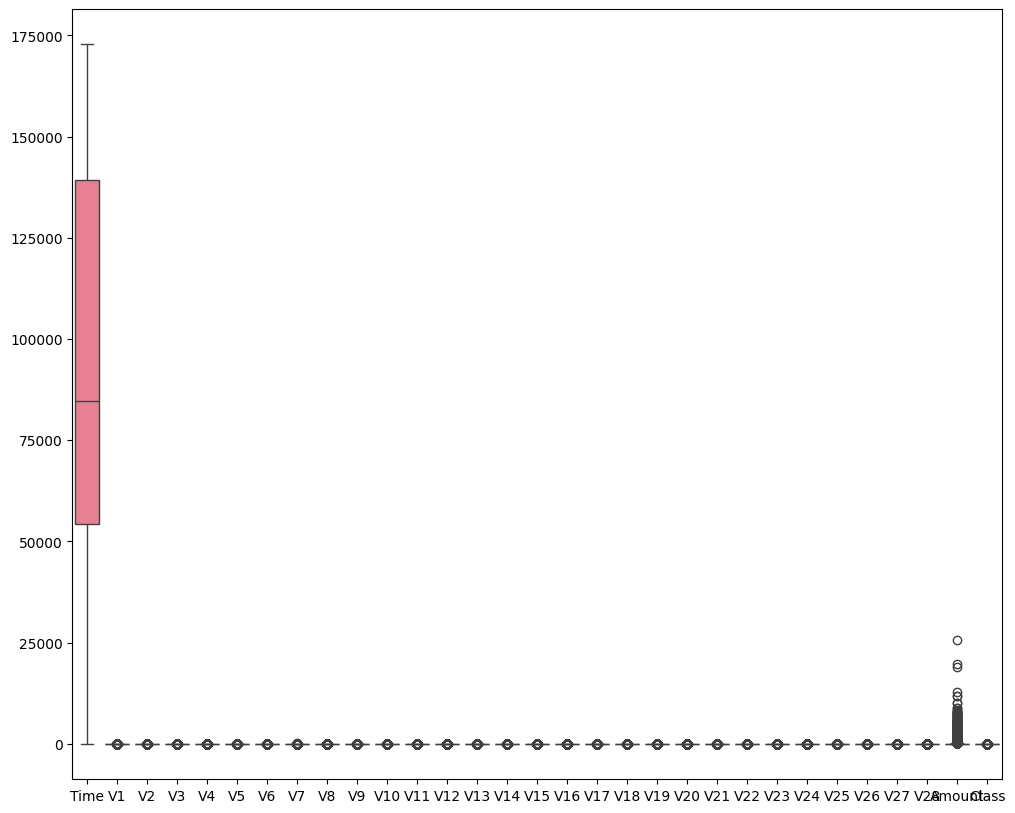

In [12]:
sns.boxplot(data=raw_df)
# Grafiğin gösterimi
plt.show()

Modeli oluşturalım:

In [13]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [14]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

SINIFLANDIRMALAR


1- Karar ağacı ile sınıflandırma -->

In [15]:
# Bağımsız ve bağımlı değişkenleri ayıralım
X = raw_df.iloc[:, :] 
y = raw_df['Class']

# Eğitim ve test setlerine ayıralım
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Karar ağacı modelini oluşturup eğitelim
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Model kullanılarak tahmin yapma
y_pred = model.predict(X_test)

# Modelin performansını değerlendirme
accuracy = accuracy_score(y_test, y_pred)
print("Doğruluk (Accuracy):", accuracy)

# Sınıflandırma raporu ve yazdırılsın
class_report = classification_report(y_test, y_pred)
print("Sınıflandırma Raporu:\n", class_report)

# Karışıklık matrisi
cm = confusion_matrix(y_test, y_pred)
print("Karışıklık Matrisi:\n", cm)

Doğruluk (Accuracy): 1.0
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      1.00      1.00        98

    accuracy                           1.00     56962
   macro avg       1.00      1.00      1.00     56962
weighted avg       1.00      1.00      1.00     56962

Karışıklık Matrisi:
 [[56864     0]
 [    0    98]]


2- K-En Yakın Komşu Yöntemi -->

In [16]:
# Bağımsız ve bağımlı değişkenleri ayıralım
X = raw_df.iloc[:, :] 
y = raw_df['Class']


# Eğitim ve test setlerine ayıralım
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=5)  # 5 komşu kullanarak model oluşturulsun
knn_model.fit(X_train, y_train)

# Modeli kullanarak tahmin yapma
y_pred = knn_model.predict(X_test)

# Modelin performansını değerlendirme
accuracy = accuracy_score(y_test, y_pred)
print("Doğruluk (Accuracy):", accuracy)

# Sınıflandırma raporu
class_report = classification_report(y_test, y_pred)
print("Sınıflandırma Raporu:\n", class_report)

# Karışıklık matrisi
cm = confusion_matrix(y_test, y_pred)
print("Karışıklık Matrisi:\n", cm)

Doğruluk (Accuracy): 0.9983673326077034
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      0.05      0.10        98

    accuracy                           1.00     56962
   macro avg       1.00      0.53      0.55     56962
weighted avg       1.00      1.00      1.00     56962

Karışıklık Matrisi:
 [[56864     0]
 [   93     5]]


3- Naive Bayes yöntemi -->

In [17]:
# Bağımsız ve bağımlı değişkenleri ayıralım
X = raw_df.iloc[:, :] 
y = raw_df['Class']
# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes modelini oluşturma ve eğitme
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Modeli kullanarak tahmin yapma
y_pred = nb_model.predict(X_test)

# Modelin performansını değerlendirme
accuracy = accuracy_score(y_test, y_pred)
print("Doğruluk (Accuracy):", accuracy)

# Sınıflandırma raporu
class_report = classification_report(y_test, y_pred)
print("Sınıflandırma Raporu:\n", class_report)

# Karışıklık matrisi
cm = confusion_matrix(y_test, y_pred)
print("Karışıklık Matrisi:\n", cm)

Doğruluk (Accuracy): 0.9930304413468628
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.15      0.63      0.24        98

    accuracy                           0.99     56962
   macro avg       0.57      0.81      0.62     56962
weighted avg       1.00      0.99      1.00     56962

Karışıklık Matrisi:
 [[56503   361]
 [   36    62]]


4- Lojistik Regresyon Yöntemi -->

In [18]:
# Lojistik Regresyon modelini oluşturup eğitelim
model = LogisticRegression(max_iter=1000, random_state=42) # "max_iter=1000" ile modelin iterayonsayısı arttırıldı.
model.fit(X_train, y_train)                                # Bu sayede kod için verilebilecek uyarı çözülmüş oldu.

# Modeli kullanarak tahmin yapma
y_pred = model.predict(X_test)

# Modelin performansını değerlendirme
accuracy = accuracy_score(y_test, y_pred)
print("Doğruluk (Accuracy):", accuracy)

# Sınıflandırma raporu
class_report = classification_report(y_test, y_pred)
print("Sınıflandırma Raporu:\n", class_report)

# Karışıklık matrisi
cm = confusion_matrix(y_test, y_pred)
print("Karışıklık Matrisi:\n", cm)

Doğruluk (Accuracy): 0.9991397773954567
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.60      0.71        98

    accuracy                           1.00     56962
   macro avg       0.93      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Karışıklık Matrisi:
 [[56854    10]
 [   39    59]]


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5- Destek Vektör Makineleri Yöntemi -->

In [19]:
# Bağımsız ve bağımlı değişkenleri ayıralım
X = raw_df.iloc[:, :] 
y = raw_df['Class']

# Veriyi ölçeklendirme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Lojistik Regresyon modelini oluşturma ve eğitme
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Modeli kullanarak tahmin yapma
y_pred = model.predict(X_test)

# Modelin performansını değerlendirme
accuracy = accuracy_score(y_test, y_pred)
print("Doğruluk (Accuracy):", accuracy)

# Sınıflandırma raporu
class_report = classification_report(y_test, y_pred)
print("Sınıflandırma Raporu:\n", class_report)

# Karışıklık matrisi
cm = confusion_matrix(y_test, y_pred)
print("Karışıklık Matrisi:\n", cm)

Doğruluk (Accuracy): 1.0
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      1.00      1.00        98

    accuracy                           1.00     56962
   macro avg       1.00      1.00      1.00     56962
weighted avg       1.00      1.00      1.00     56962

Karışıklık Matrisi:
 [[56864     0]
 [    0    98]]


6- Yapay Sinir Ağları Yöntemi -->

In [20]:
# Bağımsız ve bağımlı değişkenleri ayıralım
X = raw_df.iloc[:, :] 
y = raw_df['Class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Yapay Sinir Ağı (YSA) modelini oluşturma ve eğitme
model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
model.fit(X_train, y_train)

# Modeli kullanarak tahmin yapma
y_pred = model.predict(X_test)

# Modelin performansını değerlendirme
accuracy = accuracy_score(y_test, y_pred)
print("Doğruluk (Accuracy):", accuracy)

# Sınıflandırma raporu
class_report = classification_report(y_test, y_pred)
print("Sınıflandırma Raporu:\n", class_report)

# Karışıklık matrisi
cm = confusion_matrix(y_test, y_pred)
print("Karışıklık Matrisi:\n", cm)

Doğruluk (Accuracy): 1.0
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      1.00      1.00        98

    accuracy                           1.00     56962
   macro avg       1.00      1.00      1.00     56962
weighted avg       1.00      1.00      1.00     56962

Karışıklık Matrisi:
 [[56864     0]
 [    0    98]]


KÜMELEMELER

1- K-means Kümeleme Yöntemi -->

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V22       V23  \
0       0.462388  0.239599  0.098698  0.363787  ...  0.27783

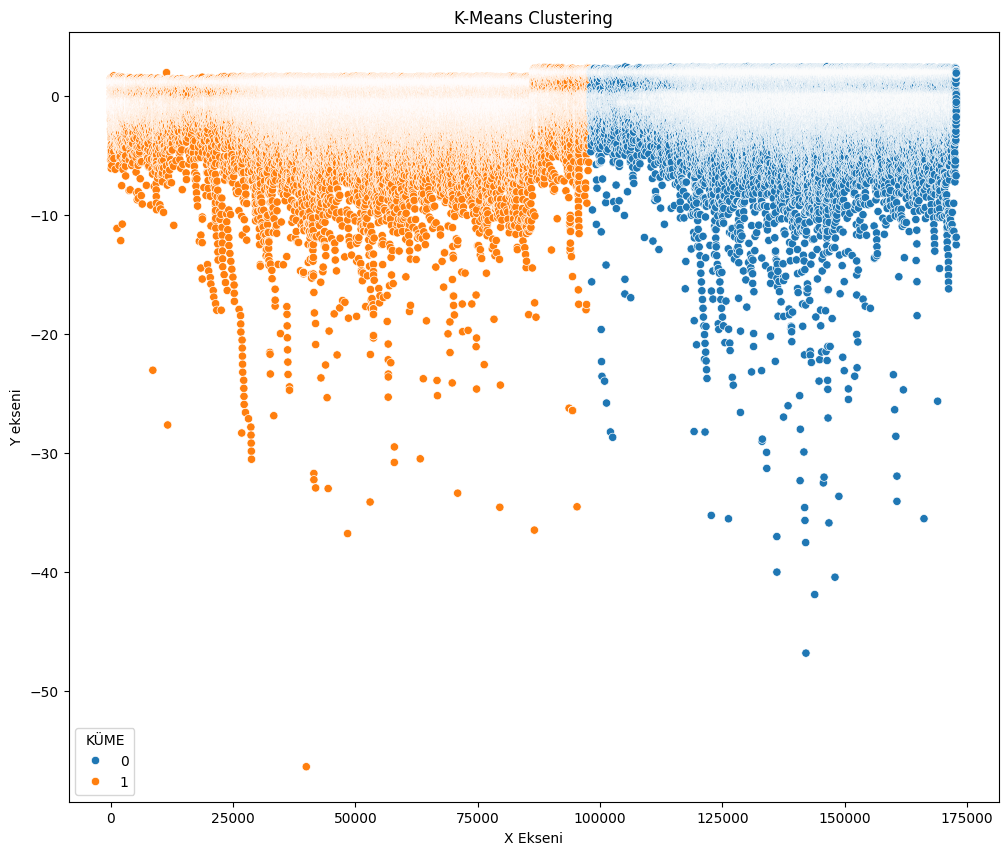

In [21]:
df_clustering = raw_df.iloc[:, :]
kmeans = KMeans(n_clusters=2, random_state=0, n_init=5)
clusters = kmeans.fit_predict(df_clustering)

# Küme etiketlerini orijinal veri kümesine ekleyelim
raw_df['KÜME'] = clusters

sns.scatterplot(x=df_clustering.iloc[:, 0], y=df_clustering.iloc[:, 1], hue=raw_df['KÜME'])
plt.title('K-Means Clustering')
plt.xlabel('X Ekseni')
plt.ylabel('Y ekseni')

# Sonuçları kaydedelim
raw_df.to_csv('clustered_data.csv', index=False)
print(raw_df)
plt.show()
# Ölçeklendirme işlemi
scaler = StandardScaler()
x_scaled = scaler.fit_transform(raw_df.iloc[:, :])
